# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications.

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below.

<img src='https://github.com/udacity/pytorch_challenge/blob/master/assets/Flowers.png?raw=1' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [ ]:
# Import necessary packages

import matplotlib.pyplot as plt
import numpy as np
import json
import random
import torch
import torchvision
import torch.utils.data
import torch.nn.functional as F
import time
from datetime import datetime
from PIL import Image
from torch import nn, optim
from torchvision import datasets, transforms, models
from collections import OrderedDict
from torch.autograd import Variable


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
# Check torch version and CUDA status if GPU is enabled
print("\n=== Environment Information ===")
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"Number of CUDA Devices: {torch.cuda.device_count()}")


=== Environment Information ===
PyTorch Version: 2.5.1+cu124
CUDA Available: True
Number of CUDA Devices: 1


In [ ]:
# imports
import os
import requests
from pathlib import Path
import tarfile

# defining dataset directory
data_dir = './flowers'

# using pathlib.Path for handling PosixPath
FLOWERS_DIR = Path(data_dir)

# downloading and setting up data if not already present
if not FLOWERS_DIR.is_dir():
    # creating directory
    FLOWERS_DIR.mkdir(parents=True, exist_ok=True)
    print(f"[INFO] Directory created: ./{FLOWERS_DIR}")

    print() # for readability

    # tarball path
    TARBALL = FLOWERS_DIR / "flower_data.tar.gz"

    # downloading and writing the tarball to './flowers' directory
    print(f"[INFO] Downloading the file 'flower_data.tar.gz' to ./{FLOWERS_DIR}")
    request = requests.get('https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz')
    with open(TARBALL, "wb") as file_ref:
        file_ref.write(request.content)
        print(f"[INFO] 'flower_data.tar.gz' saved to ./{FLOWERS_DIR}")

    print() # for readability

    # extracting the downloaded tarball
    print(f"[INFO] Extracting the downloaded tarball to ./{FLOWERS_DIR}")
    with tarfile.open(TARBALL, "r") as tar_ref:
        tar_ref.extractall(FLOWERS_DIR)
        print(f"[INFO] 'flower_data.tar.gz' extracted successfully to ./{FLOWERS_DIR}")

    print() # for readability

    # using os.remove to delete the downloaded tarball
    print("[INFO] Deleting the tarball to save space.")
    os.remove(TARBALL)
else:
    print(f"[INFO] Dataset already setup at ./{FLOWERS_DIR}")

[INFO] Directory created: ./flowers

[INFO] Downloading the file 'flower_data.tar.gz' to ./flowers
[INFO] 'flower_data.tar.gz' saved to ./flowers

[INFO] Extracting the downloaded tarball to ./flowers
[INFO] 'flower_data.tar.gz' extracted successfully to ./flowers

[INFO] Deleting the tarball to save space.


In [ ]:
data = {
    "21": "fire lily", "3": "canterbury bells", "45": "bolero deep blue", "1": "pink primrose", "34": "mexican aster",
    "27": "prince of wales feathers", "7": "moon orchid", "16": "globe-flower", "25": "grape hyacinth", "26": "corn poppy",
    "79": "toad lily", "39": "siam tulip", "24": "red ginger", "67": "spring crocus", "35": "alpine sea holly",
    "32": "garden phlox", "10": "globe thistle", "6": "tiger lily", "93": "ball moss", "33": "love in the mist",
    "9": "monkshood", "102": "blackberry lily", "14": "spear thistle", "19": "balloon flower", "100": "blanket flower",
    "13": "king protea", "49": "oxeye daisy", "15": "yellow iris", "61": "cautleya spicata", "31": "carnation",
    "64": "silverbush", "68": "bearded iris", "63": "black-eyed susan", "69": "windflower", "62": "japanese anemone",
    "20": "giant white arum lily", "38": "great masterwort", "4": "sweet pea", "86": "tree mallow",
    "101": "trumpet creeper", "42": "daffodil", "22": "pincushion flower", "2": "hard-leaved pocket orchid",
    "54": "sunflower", "66": "osteospermum", "70": "tree poppy", "85": "desert-rose", "99": "bromelia", "87": "magnolia",
    "5": "english marigold", "92": "bee balm", "28": "stemless gentian", "97": "mallow", "57": "gaura",
    "40": "lenten rose", "47": "marigold", "59": "orange dahlia", "48": "buttercup", "55": "pelargonium",
    "36": "ruby-lipped cattleya", "91": "hippeastrum", "29": "artichoke", "71": "gazania", "90": "canna lily",
    "18": "peruvian lily", "98": "mexican petunia", "8": "bird of paradise", "30": "sweet william",
    "17": "purple coneflower", "52": "wild pansy", "84": "columbine", "12": "colt's foot", "11": "snapdragon",
    "96": "camellia", "23": "fritillary", "50": "common dandelion", "44": "poinsettia", "53": "primula",
    "72": "azalea", "65": "californian poppy", "80": "anthurium", "76": "morning glory", "37": "cape flower",
    "56": "bishop of llandaff", "60": "pink-yellow dahlia", "82": "clematis", "58": "geranium", "75": "thorn apple",
    "41": "barbeton daisy", "95": "bougainvillea", "43": "sword lily", "83": "hibiscus", "78": "lotus lotus",
    "88": "cyclamen", "94": "foxglove", "81": "frangipani", "74": "rose", "89": "watercress", "73": "water lily",
    "46": "wallflower", "77": "passion flower", "51": "petunia"
}

## Data Description
The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [ ]:
# Define directories
data_dir = 'flowers'
train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'valid')
test_dir = os.path.join(data_dir, 'test')

In [ ]:
# TODO: Define your transforms for the training, validation, and testing sets
# Define transforms
train_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

valid_test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# TODO: Load the datasets with ImageFolder

# Load datasets
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_test_transforms)
test_data = datasets.ImageFolder(test_dir, transform=valid_test_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders

# Define dataloaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=32)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [ ]:
with open('cat_to_name.json', 'w') as file:
    json.dump(data, file)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [ ]:
# TODO: Build and train your network

def create_neural_network(structure='resnet50', learning_rate=1e-3):
    """
    Creates a neural network with a pre-trained backbone and custom classification
    head using nn.Sequential for the classifier architecture.
    """
    print(f"\n[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Creating model...")

    # Select base model based on structure parameter
    if structure == 'resnet50':
        base_model = models.resnet50(pretrained=True)
    else:
        raise ValueError(f"Unsupported model structure: {structure}")

    # Freeze pre-trained layers
    for param in base_model.parameters():
        param.requires_grad = False

    # Create custom classification head using OrderedDict
    classification_head = nn.Sequential(OrderedDict([
        ('fc1', nn.Linear(2048, 512, bias=True)),
        ('drop', nn.Dropout(p=0.3)),
        ('relu', nn.ReLU()),
        ('fc2', nn.Linear(512, 102, bias=True)),
        ('output', nn.LogSoftmax(dim=1))
    ]))

    # Replace final layer with custom head
    base_model.fc = classification_head

    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\n[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Moving model to device...")
    start_time = time.time()
    base_model = base_model.to(device)
    move_time = time.time() - start_time
    print(f"[{move_time:.2f}s] Model moved to {device}")

    # Verify model is on GPU
    #print(f"Model parameters on device: {next(base_model.parameters()).device}")

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(base_model.fc.parameters(), lr=learning_rate)

    print(f"\n[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Model creation completed.")
    return base_model, criterion, optimizer

In [ ]:
# Create train_and_validate function with debugging
def train_and_validate(base_model, trainloader, validloader, criterion, optimizer, epochs=20):
    """
    Trains the model and validates its performance during training.
    Args:
        base_model: the neural network model
        trainloader: training data loader
        validloader: validation data loader
        criterion: loss function
        optimizer: optimizer instance
        epochs: number of training epochs
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    base_model.to(device)
    print(f"\n[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Starting training...")

    for epoch in range(epochs):
        base_model.train()
        running_loss = 0

        # Training loop
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = base_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Validation loop
        base_model.eval()
        valid_loss = 0
        accuracy = 0
        with torch.no_grad():
            for inputs, labels in validloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = base_model(inputs)
                valid_loss += criterion(outputs, labels).item()
                ps = torch.exp(outputs)
                equality = (labels == ps.max(1)[1])
                accuracy += equality.type(torch.FloatTensor).mean().item()

        print(f"Epoch: {epoch+1}/{epochs}... "
              f"Training Loss: {running_loss/len(trainloader):.3f}... "
              f"Validation Loss: {valid_loss/len(validloader):.3f}... "
              f"Accuracy: {(accuracy/len(validloader))*100:.3f}")

    print(f"\n[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Training completed.")

# Run the model with debugging
print("\n=== Starting Training Process ===")
start_time = time.time()

base_model, criterion, optimizer = create_neural_network()
train_and_validate(base_model, train_loader,
                   valid_loader, criterion, optimizer)

end_time = time.time()
total_time = end_time - start_time
print(f"\nTraining completed in {total_time:.2f}s")


=== Starting Training Process ===

[2025-02-09 09:29:23] Creating model...

[2025-02-09 09:29:23] Moving model to device...
[0.04s] Model moved to cuda

[2025-02-09 09:29:23] Model creation completed.

[2025-02-09 09:29:23] Starting training...
Epoch: 1/20... Training Loss: 3.760... Validation Loss: 2.299... Accuracy: 46.768
Epoch: 2/20... Training Loss: 2.302... Validation Loss: 1.183... Accuracy: 74.933
Epoch: 3/20... Training Loss: 1.738... Validation Loss: 0.890... Accuracy: 77.631
Epoch: 4/20... Training Loss: 1.475... Validation Loss: 0.706... Accuracy: 83.494
Epoch: 5/20... Training Loss: 1.350... Validation Loss: 0.619... Accuracy: 84.642
Epoch: 6/20... Training Loss: 1.250... Validation Loss: 0.569... Accuracy: 83.520
Epoch: 7/20... Training Loss: 1.182... Validation Loss: 0.535... Accuracy: 86.111
Epoch: 8/20... Training Loss: 1.102... Validation Loss: 0.479... Accuracy: 87.313
Epoch: 9/20... Training Loss: 1.090... Validation Loss: 0.450... Accuracy: 89.236
Epoch: 10/20... 

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [ ]:
# TODO: Do validation on the test set
def evaluate_model(base_model, testloader, criterion):
    """
    Evaluate the model on the test dataset.
    Args:
        base_model: the neural network model.
        testloader: test data loader.
        criterion: loss function.
    Expected output:
        tuple: (test_loss, accuracy)
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    base_model.to(device)

    # Initialize metrics
    total_loss = 0
    accuracy = 0

    # Set model to evaluation mode
    base_model.eval()

    # Disable gradient computation
    with torch.no_grad():
        # Iterate through test batches
        for inputs, labels in testloader:
            # Move data to GPU
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = base_model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Calculate accuracy
            ps = torch.exp(outputs)
            equality = (labels.data == ps.max(1)[1])
            accuracy += equality.type_as(torch.FloatTensor()).mean().item()

    # Calculate average loss
    avg_loss = total_loss / len(testloader)

    # Calculate accuracy percentage
    accuracy_percentage = (accuracy / len(testloader)) * 100

    # Print the test loss and accuracy results
    print(f"Test Loss: {avg_loss:.3f}")
    print(f"Testing Accuracy: {accuracy_percentage:.3f}%")

    return avg_loss, accuracy_percentage

# Evaluate on test set
test_loss, accuracy = evaluate_model(base_model, test_loader, criterion)

Test Loss: 0.391
Testing Accuracy: 88.373%


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [ ]:
# TODO: Save the checkpoint

def save_checkpoint(base_model, optimizer, epochs, train_data, learning_rate, batch_size, checkpoint_name='checkpoint.pth'):
    """
    Saves a checkpoint containing model state, optimizer state, and training information.

    Args:
        base_model: neural network model
        optimizer: Optimizer instance
        epochs: Number of epochs trained
        train_data: Training dataset object
        learning_rate: Learning rate used during training
        batch_size: Batch size used during training
        checkpoint_name: Name of the checkpoint file to save
    """
    checkpoint = {
        'input_size': 2048,
        'output_size': 102,
        'arch': 'resnet50',
        'learning_rate': learning_rate,
        'batch_size': batch_size,
        'classifier': base_model.fc,
        'epochs': epochs,
        'optimizer_state': optimizer.state_dict(),
        'state_dict': base_model.state_dict(),
        'class_to_idx': train_data.class_to_idx
    }

    torch.save(checkpoint, checkpoint_name)
    print(f"\nCheckpoint saved successfully as {checkpoint_name}")

# Function usage
epochs = 20
save_checkpoint(base_model, optimizer, epochs, train_data, learning_rate=0.001, batch_size=64)


Checkpoint saved successfully as checkpoint.pth


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [ ]:
# TODO: Write a function that loads a checkpoint and rebuilds the model

def load_checkpoint(checkpoint_path='checkpoint.pth'):
    """
    Loads a checkpoint containing model state, optimizer state, and training information.

    Args:
        checkpoint_path: Path to the checkpoint file

    Returns:
        tuple: (loaded_model, optimizer)
    """
    # Load the checkpoint
    checkpoint = torch.load(checkpoint_path)

    # Create model instance
    model = models.resnet50(pretrained=True)
    model.fc = checkpoint['classifier']

    # Load model state dict
    model.load_state_dict(checkpoint['state_dict'])

    # Initialize and load optimizer state
    optimizer = optim.Adam(model.fc.parameters(), lr=checkpoint['learning_rate'])
    optimizer.load_state_dict(checkpoint['optimizer_state'])

    # Load class_to_idx
    model.class_to_idx = checkpoint['class_to_idx']

    return model, optimizer

# Function usage
model, optimizer = load_checkpoint('checkpoint.pth')
model.eval()

<ipython-input-18-55e952d459a4>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)
/usr/local/lib/python3.11/dist-packages/torchvisio

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network.

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training.

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation.

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [ ]:
def process_image(image_path):
    """ Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array.
    """
     # TODO: Process a PIL image for use in a PyTorch model

    try:
        # Check if file exists
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image file not found: {image_path}")

        # Load and validate image
        with Image.open(image_path) as img:
            if img is None:
                raise ValueError("Failed to open image")

            # Resize and crop image
            img = img.resize((256, 256))
            img = img.crop((16, 16, 240, 240))

            # Convert image to numpy array and normalize
            img = np.array(img) / 255
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img = (img - mean) / std

            # Transpose image dimensions
            img = img.transpose((2, 0, 1))

            # Convert to tensor
            img_tensor = torch.from_numpy(img).float()
            return img_tensor

    except Exception as e:
        print(f"Error processing image: {str(e)}")
        return None

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [ ]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()

    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))

    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)

    ax.imshow(image)

    return ax

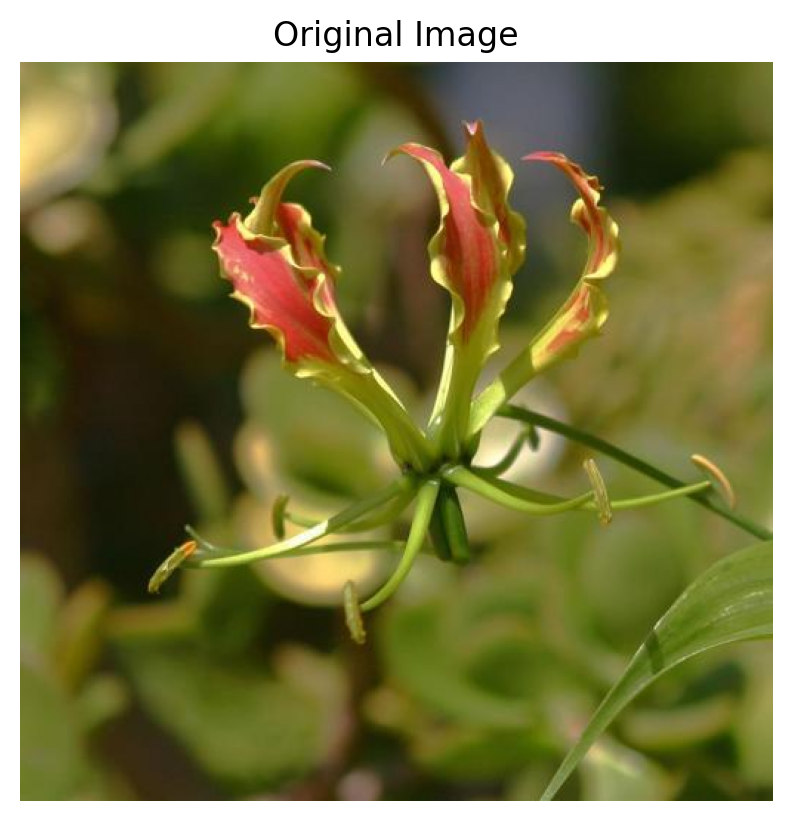

In [ ]:
def show_original_image(image_path):
    """Show the original image before any preprocessing."""
    try:
        # Check if file exists
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image file not found: {image_path}")

        # Load and validate image
        with Image.open(image_path) as img:
            if img is None:
                raise ValueError("Failed to open image")

            # Display the original image
            plt.imshow(img)
            plt.axis('off')  # Hide axes
            plt.title("Original Image")
            plt.show()

    except Exception as e:
        print(f"Error displaying image: {str(e)}")

# Function usage
img = random.choice(os.listdir('./flowers/test/21/'))
img_path = './flowers/test/21/' + img
show_original_image(img_path)

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [ ]:
def predict(image_path, model, topk=5):
    """Predict the class (or classes) of an image using a trained deep learning model."""

    # Set the model to evaluation mode
    model.eval()

    # Define the device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Move the model to the appropriate device
    model.to(device)

    # Process the image
    image = process_image(image_path)

    # Add a batch dimension and move the image to the appropriate device
    image = image.unsqueeze(0).to(device)

    # Disable gradient computation
    with torch.no_grad():
        # Forward pass
        output = model.forward(image)

    # Calculate probabilities
    ps = torch.exp(output)

    # Get the top k probabilities and their corresponding classes
    top_p, top_class = ps.topk(topk, dim=1)

    # Move the results to the CPU and convert to numpy arrays
    top_p = top_p.cpu().numpy()[0]
    top_class = top_class.cpu().numpy()[0]

    # Map the indices to the actual class labels
    idx_to_class = {v: k for k, v in model.class_to_idx.items()}
    top_class = [idx_to_class[i] for i in top_class]

    # Print the probabilities and classes
    print("Prediction successful:")
    print("Probabilities:", top_p)
    print("Classes:", top_class)

    return top_p, top_class

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [ ]:
def display_prediction(image_path, model, cat_to_name, topk=5):
    """Display the prediction results for an image."""
    prob, classes = predict(image_path, model, topk=topk)

    # Select the class with the highest probability
    max_index = np.argmax(prob)
    label = classes[max_index]

    # Create the figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    # Display the image
    image = Image.open(image_path)
    ax1.axis('off')
    ax1.set_title(cat_to_name[label])
    ax1.imshow(image)

    # Prepare the labels for the bar plot
    labels = [cat_to_name[cl] for cl in classes]

    # Create the bar plot
    y_pos = np.arange(topk)
    ax2.set_xticks(y_pos)
    ax2.set_xticklabels(labels, rotation=45, ha='right')
    ax2.set_ylabel('Probability')
    ax2.bar(y_pos, prob, align='center', color='blue')

    plt.tight_layout()
    plt.show()

Prediction successful:
Probabilities: [0.6398247  0.21163176 0.06887014 0.04865263 0.01813135]
Classes: ['21', '37', '92', '61', '24']


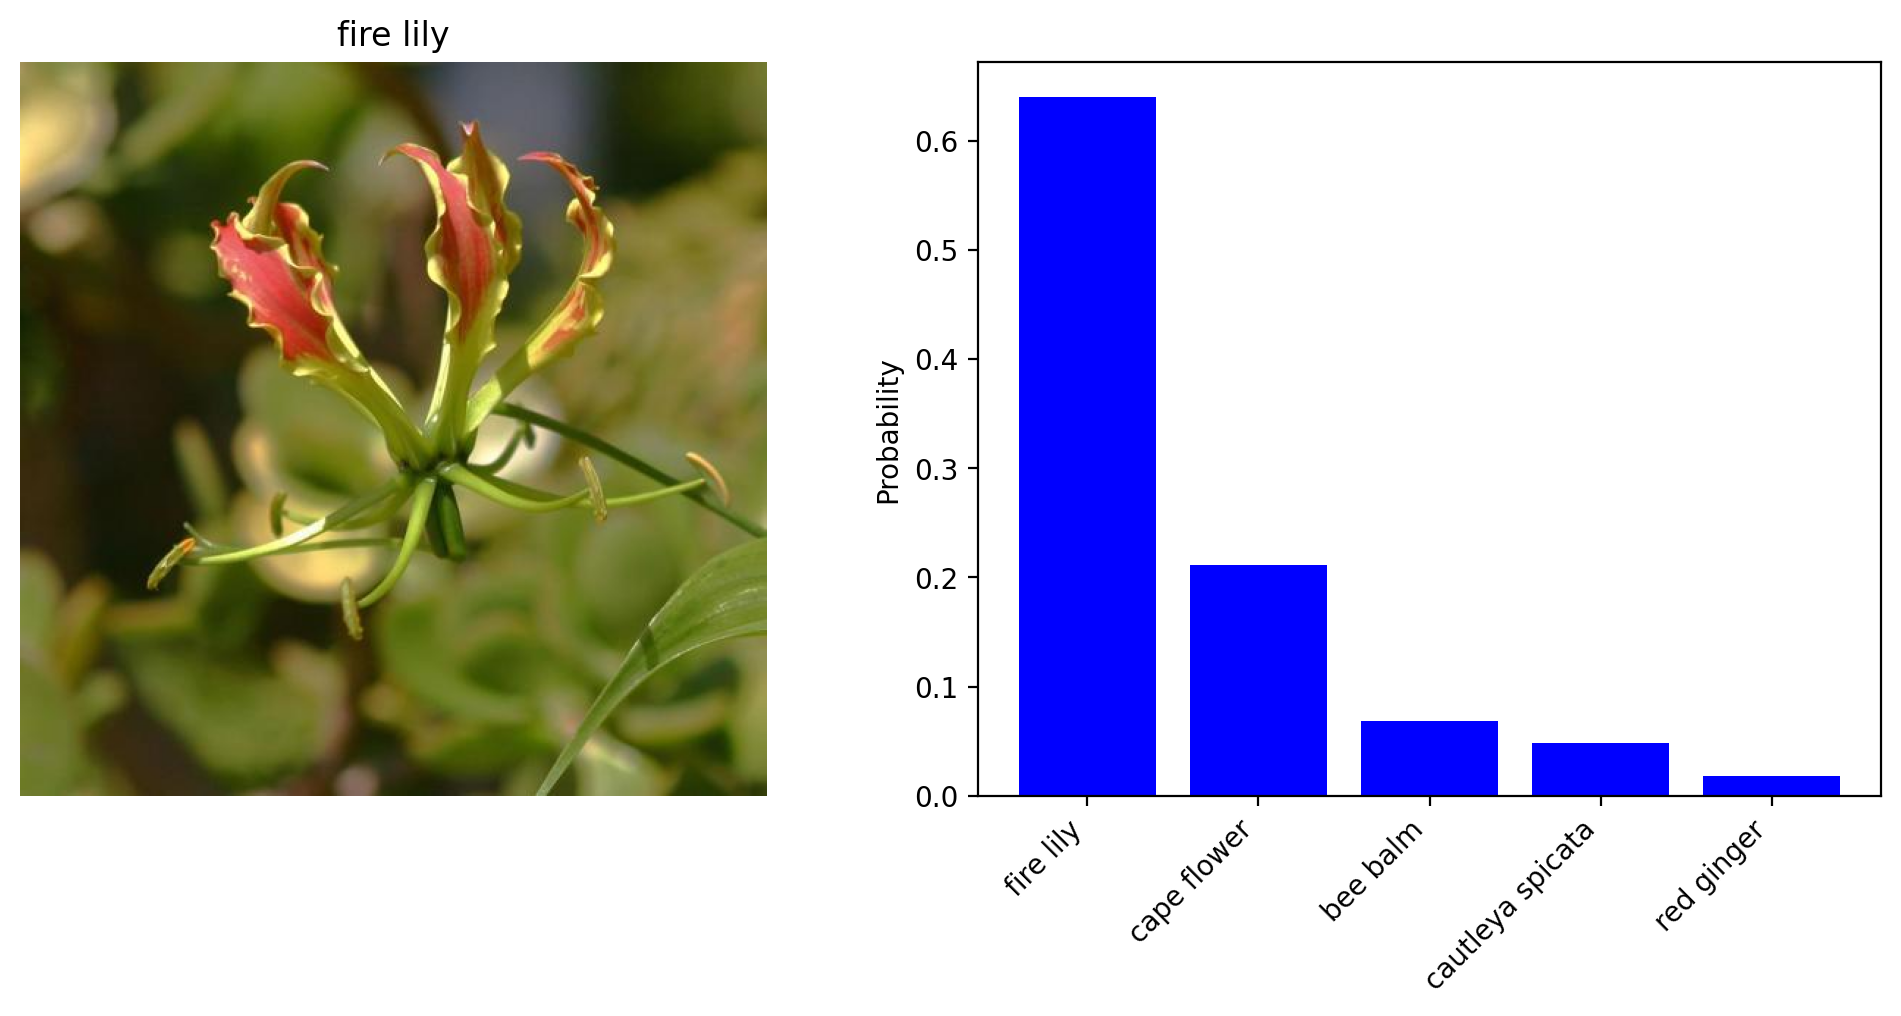

In [ ]:
# Show image and probabilities

# Load the category to name mapping
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Select a random image from the specified directory
image_path = random.choice(os.listdir('./flowers/test/21/'))
image_path = os.path.join('./flowers/test/21/', image_path)

# Display the prediction
display_prediction(image_path, model, cat_to_name)